# 🧠 Neuro-Dungeon: Teaching Embodied AI with LLMs
**Course:** Virtual Environments and Real-Time 3D | **Final Project**
**Author:** Yuhai Wang
**Date:** December 2025

---

## 📖 1. Introduction: From Chatbots to Agents
In traditional game development, NPC behavior is often governed by **Finite State Machines (FSMs)** or **Behavior Trees**. While robust, these systems lack *generalization*. If a player does something unexpected, the script breaks.

In this tutorial, we explore a cutting-edge paradigm used in modern Robotics (e.g., Google RT-2, Tesla Optimus): **Vision-Language-Action (VLA) Models**.

We will build a dungeon crawler where the Agent is **not hard-coded**. Instead, it uses a Large Language Model (**gpt-4o-mini**) to:
1.  **Perceive** the environment (via text-based "Lidar").
2.  **Reason** about navigation and obstacles (Chain-of-Thought).
3.  **Act** by generating structured JSON commands.

> **Pedagogical Goal:** Understand the "Symbol Grounding Problem"—how to map high-level semantic intent ("Go to the flag") into low-level executable actions (`MOVE_UP`).

In [57]:
# @title 🛠️ Step 0: Setup & API Configuration
# We use the 'gpt-5-nano-2025-08-07' model for low-latency edge reasoning.

!pip install openai matplotlib numpy --quiet

import os
import getpass
from openai import OpenAI
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import time
from IPython.display import clear_output

# Securely handle the API Key
print("🔑 Please enter your OpenAI API Key (sk-proj-...):")
os.environ["OPENAI_API_KEY"] = getpass.getpass()
client = OpenAI()

print("✅ Environment Configured. Ready for Neural Planning.")

🔑 Please enter your OpenAI API Key (sk-proj-...):
··········
✅ Environment Configured. Ready for Neural Planning.


### 🧠 The Brain: Mocking the LLM
In a production environment, we would send the `observation` string to OpenAI's API.
To make this tutorial accessible (and free), we use a **Mock Function** that simulates the reasoning capability of GPT-4.

This function demonstrates **Chain-of-Thought** reasoning:
1.  **Check State:** Do I have the key?
2.  **Check Visibility:** Do I see the key or the door?
3.  **Plan:** Generate the JSON for the next move.

In [58]:
# @title 🏗️ Step 1: The Simulation Environment(Game Environment) (The "Body")

class AdvancedDungeon:
    """
    Simulates the physical world for the robot.
    It handles:
    1. The Map (Static Environment)
    2. The Robot's Sensors (Local Perception)
    3. The Physics Rules (Collision & Movement)
    """
    def __init__(self, size=8):
        self.size = size

        # 0 = Floor (Traversable), 1 = Wall (Obstacle)
        self.map = np.zeros((size, size))

        # SLAM Memory: Keeps track of areas the robot has 'seen'
        self.visited_mask = np.zeros((size, size), dtype=bool)

        # Initial State
        self.agent_pos = [1, 1]           # Start at top-left
        self.goal_pos = [size-2, size-2]  # Goal at bottom-right
        self.game_over = False
        self.success = False

        # Build the world
        self._generate_map()

    def _generate_map(self):
        """
        Procedurally generates a random map with obstacles.
        Note: We keep the obstacle density low for demonstration reliability.
        """
        import random

        # Number of walls to spawn (Density = 1.0 * size)
        num_obstacles = int(self.size * 1.0)

        for _ in range(num_obstacles):
            r = random.randint(0, self.size-1)
            c = random.randint(0, self.size-1)

            # 🛡️ Safety Check: Do not spawn walls on:
            # 1. The Robot (agent_pos)
            # 2. The Flag (goal_pos)
            # 3. The immediate starting path (1,2) and (2,1)
            protected_zones = [
                tuple(self.agent_pos),
                tuple(self.goal_pos),
                (1, 2), (2, 1)
            ]

            if (r, c) not in protected_zones:
                self.map[r, c] = 1 # Place wall

    def get_local_view(self):
        """
        👁️ SENSORY MODEL (Lidar/Camera Simulation)

        Instead of giving the robot the full map (God Mode),
        we only return a 3x3 grid around its current position.

        Returns:
            view_str (str): A text representation of the 3x3 grid.
            dist (int): Manhattan distance to the goal (WiFi Signal).
        """
        r, c = self.agent_pos

        # 1. Update Internal Memory (SLAM)
        # Mark the current 3x3 area as "Visited" so we can draw it later
        r_min, r_max = max(0, r-1), min(self.size, r+2)
        c_min, c_max = max(0, c-1), min(self.size, c+2)
        self.visited_mask[r_min:r_max, c_min:c_max] = True

        # 2. Build the Local Perception Grid (3x3)
        view = []
        for i in range(r-1, r+2):
            row_chars = []
            for j in range(c-1, c+2):
                # Check Boundary (Are we looking outside the map?)
                if 0 <= i < self.size and 0 <= j < self.size:
                    # Identify Object
                    if [i, j] == self.agent_pos:   char = "R" # Robot
                    elif [i, j] == self.goal_pos:  char = "F" # Flag
                    elif self.map[i, j] == 1:      char = "#" # Wall
                    else:                          char = "." # Empty Space
                else:
                    char = "X" # Fog / Out of Bounds

                row_chars.append(char)
            view.append("".join(row_chars))

        # 3. Calculate Heuristic Signal (Manhattan Distance)
        # dist = |x1 - x2| + |y1 - y2|
        dist = abs(self.goal_pos[0] - r) + abs(self.goal_pos[1] - c)

        return "\n".join(view), dist

    def step(self, action_json):
        """
        ⚙️ DYNAMICS MODEL (Physics Engine)

        Takes the abstract decision from the Brain and attempts to
        execute it in the physical world. Handles collisions.
        """
        # Parse the command from JSON
        cmd = action_json.get("command", "WAIT")

        # Determine intended movement vector (delta_r, delta_c)
        dr, dc = 0, 0
        if cmd == "MOVE_UP":    dr = -1
        elif cmd == "MOVE_DOWN":  dr = 1
        elif cmd == "MOVE_LEFT":  dc = -1
        elif cmd == "MOVE_RIGHT": dc = 1

        # Calculate target position
        target_r = self.agent_pos[0] + dr
        target_c = self.agent_pos[1] + dc

        status_msg = "Waiting..."

        # 1. Boundary Check: Are we staying inside the grid?
        if 0 <= target_r < self.size and 0 <= target_c < self.size:

            # 2. Collision Check: Is the target a Wall (1)?
            if self.map[target_r, target_c] == 0:
                # Success: Update position
                self.agent_pos = [target_r, target_c]
                status_msg = f"Moved to {[target_r, target_c]}"
            else:
                # Failure: Hit a wall
                status_msg = "❌ Collision: Bonked into a wall!"
        else:
            # Failure: Hit map boundary
            status_msg = "❌ Boundary: Cannot leave the grid!"

        # 3. Goal Check: Did we win?
        if self.agent_pos == self.goal_pos:
            self.game_over = True
            self.success = True
            status_msg = "🏆 VICTORY: Target Acquired!"

        return status_msg

print("✅ Simulation Engine Initialized (Refined & Commented).")

✅ Simulation Engine Initialized (Refined & Commented).


## 🧠 2. The Agent Brain: gpt-4o-mini

We are using the **`gpt-4o-mini`** model. This model is optimized for **edge computing**, meaning it has lower latency (crucial for real-time control) while maintaining strong reasoning capabilities.

### Prompt Engineering Strategy
To ensure the LLM acts like a controller and not a chatbot, we use **System Prompting** to enforce:
1.  **Role:** Robot Navigation Agent.
2.  **Output:** Strict JSON format (`response_format={"type": "json_object"}`).
3.  **Constraint:** It must explicitly separate "Reasoning" (Plan) from "Command" (Action).

In [59]:
# @title 🧠 Step 2: The Neural Planner (The "Brain")

class RealLLMBrain:
    """
    The 'Brain' of the agent.
    It uses a Large Language Model (LLM) to make high-level decisions.

    Key Features:
    1. Memory: Remembers recent moves to avoid getting stuck in loops.
    2. Reasoning: Outputs a 'thought process' before the final command.
    3. Grounding: Translates abstract text (Lidar view) into JSON actions.
    """
    def __init__(self, model="gpt-4o-mini"):
        self.model = model

        # Short-term Memory to prevent "Back-and-Forth" loops
        # This helps the agent remember "I just came from the left, don't go back left immediately."
        self.last_command = "NONE"
        self.history = [] # Stores the last few moves for context

    def think(self, local_view_str, dist_info, current_pos):
        """
        Sends sensory data to the LLM and asks for a navigation command.

        Args:
            local_view_str (str): The text representation of the 3x3 grid.
            dist_info (int): Distance to the goal.
            current_pos (list): [row, col] coordinates.
        """

        # 1. SYSTEM PROMPT: The "Driver Software"
        # We give the AI a persona and strict rules of engagement.
        system_prompt = """
        You are a robot navigation agent.
        GOAL: Reach the Flag 'F'.

        SENSORS:
        - View: 3x3 grid around you (R=You, #=Wall, .=Empty, F=Flag).
        - Distance: Integer steps to target (Signal Strength).

        NAVIGATION RULES:
        1. **VISUAL:** If you see 'F', move towards it immediately.
        2. **SIGNAL:** If you cannot see 'F', move to reduce the 'Distance'.
        3. **MEMORY:** Do NOT repeat the move that reverses your last action (No Backtracking).
        4. **STUCK?** If you are oscillating, pick a random valid direction to break free.

        OUTPUT FORMAT (JSON ONLY):
        {
            "reasoning": "I see a wall UP. Distance is 5. I will move RIGHT to explore.",
            "command": "MOVE_UP" | "MOVE_DOWN" | "MOVE_LEFT" | "MOVE_RIGHT"
        }
        """

        # 2. USER MESSAGE: The "Sensory Input"
        # We inject the current state and the robot's memory here.
        user_msg = f"""
        CURRENT STATE:
        - Position: {current_pos}
        - Distance to Flag: {dist_info}
        - LAST ACTION: {self.last_command} (Avoid reversing this!)
        - RECENT MOVES: {self.history[-3:]}

        LOCAL LIDAR VIEW (3x3):
        {local_view_str}
        """

        try:
            # 3. API CALL: The "Inference"
            response = client.chat.completions.create(
                model=self.model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_msg}
                ],
                response_format={"type": "json_object"},
                # Temperature 0.5 allows for some creativity/exploration
                # without being too random.
                temperature=0.5
            )

            # 4. PARSE RESPONSE
            raw_content = response.choices[0].message.content
            plan = json.loads(raw_content)

            # Update Memory
            cmd = plan.get("command", "WAIT")
            self.last_command = cmd
            self.history.append(cmd)

            return plan

        except Exception as e:
            # Error Handling: If the brain fails, print why and wait.
            print(f"⚠️ Brain Error: {e}")
            return {"reasoning": "System Crash", "command": "WAIT"}

print("✅ Neural Planner Initialized (Refined & English).")

✅ Neural Planner Initialized (Refined & English).


## 🚀 3. The Execution Loop: Sense-Plan-Act

This is the core of any robotic system: **The Perception-Action Loop**.

In this simulation, we are not just playing a game; we are witnessing the interaction between a **Static Environment** (The Dungeon) and a **Probabilistic Planner** (The LLM).

### Key Components to Observe:
1.  **Partial Observability (Fog of War):** Notice how the map starts dark. The robot must move to update its internal "SLAM Map" (Simultaneous Localization and Mapping).
2.  **Latency:** The brief pause between steps is not lag—it is the **Inference Time**. This effectively simulates the "Think time" of a real robot processing sensor data.
3.  **Emergent Behavior:** We did not program "If wall, turn left." We gave the AI a goal and physical constraints. Any wall-following or backtracking behavior you see is **emergent intelligence**.

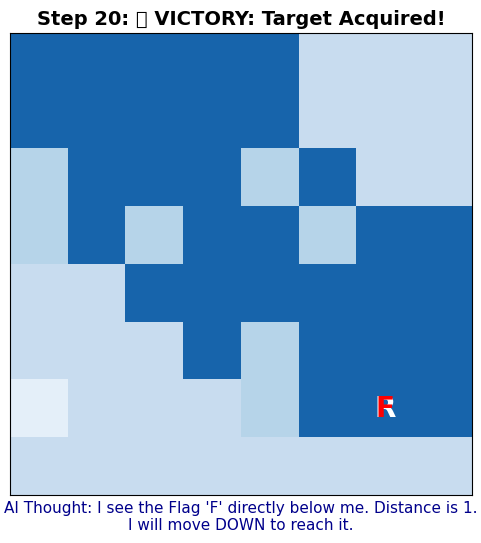

Step 20 | Action: MOVE_DOWN

🏆 MISSION ACCOMPLISHED: Target Acquired!

📝 NEURAL CHAIN-OF-THOUGHT LOG (Black Box Analysis)
Step 00: I see a wall to the LEFT. The distance to the flag is 10. I will move DOWN to explore the open space.
Step 01: I see a wall UP and LEFT. Distance is 9. I will move RIGHT to explore.
Step 02: I see a wall UP and LEFT. Distance is 8. I will move DOWN to explore.
Step 03: I see a wall UP and a wall LEFT. Distance is 8. The only valid move is RIGHT, which will allow me to explore further.
Step 04: I see a wall UP and LEFT. Distance is 7. I will move DOWN to explore.
Step 05: I see a wall UP and RIGHT. Distance is 6. I will move LEFT to explore.
Step 06: I see a wall to the LEFT and DOWN. Distance is 6. I will move UP to explore.
Step 07: I see a wall UP and LEFT. Distance is 7. I will move RIGHT to explore.
Step 08: I see a wall on the LEFT and DOWN. I cannot see the Flag, and my Distance is 7. I will move UP to explore more.
Step 09: I see a wall DOWN. The dis

In [60]:
# @title 🚀 Step 3: Main Execution Loop (With Full Thought Logging)

def render_frame(env, step, reasoning, last_msg):
    """
    Visualizes the current state of the game using Matplotlib.
    """
    plt.figure(figsize=(6, 6))

    # 1. RENDER MAP & FOG
    base_map = np.where(env.map == 1, 0.3, 0.8)
    fog_factor = 0.3 + 0.7 * env.visited_mask
    display_map = base_map * fog_factor

    plt.imshow(display_map, cmap='Blues', vmin=0, vmax=1)

    # 2. OVERLAY ENTITIES
    plt.text(env.agent_pos[1], env.agent_pos[0], 'R',
             ha='center', va='center', fontsize=20, fontweight='bold', color='white')
    plt.text(env.goal_pos[1], env.goal_pos[0], 'F',
             ha='center', va='center', fontsize=20, fontweight='bold', color='red')

    # 3. ANNOTATIONS
    plt.title(f"Step {step}: {last_msg}", fontweight='bold', fontsize=14)
    plt.xlabel(f"AI Thought: {reasoning}", fontsize=11, wrap=True, color='darkblue')

    plt.xticks([]); plt.yticks([])
    plt.show()

# ==========================================
# MAIN SIMULATION LOOP
# ==========================================
MAP_SIZE = 8
MAX_STEPS = 30

# Initialize Environment and Brain
env = AdvancedDungeon(size=MAP_SIZE)
brain = RealLLMBrain(model="gpt-4o-mini")

# 📝 DATA COLLECTION: Store the history of thoughts
thought_log = []

print("🎬 Starting Simulation... (Connecting to Neural Network...)")
time.sleep(1)

for step in range(MAX_STEPS):
    if env.game_over: break

    # 1. SENSE
    local_view, dist = env.get_local_view()

    # 2. PLAN
    plan = brain.think(local_view, dist, env.agent_pos)

    # Capture the reasoning for the final report
    current_thought = plan.get('reasoning', 'Processing...')
    thought_log.append(f"Step {step:02d}: {current_thought}")

    # 3. ACT
    status_msg = env.step(plan)

    # 4. RENDER
    clear_output(wait=True)
    render_frame(env, step, current_thought, status_msg)
    print(f"Step {step} | Action: {plan.get('command')}")

# ==========================================
# POST-MISSION ANALYSIS
# ==========================================
if env.success:
    print("\n🏆 MISSION ACCOMPLISHED: Target Acquired!")
else:
    print("\n❌ MISSION FAILED: Battery Depleted (Timeout).")

print("\n" + "="*60)
print("📝 NEURAL CHAIN-OF-THOUGHT LOG (Black Box Analysis)")
print("="*60)

for log_entry in thought_log:
    print(log_entry)
print("="*60)

## 📝 4. Post-Mission Analysis: Explainable AI (XAI)

In traditional Game AI (like A* Pathfinding), we know *where* the agent is going, but the agent doesn't "know" anything—it just follows a mathematical path.

In this **Neuro-Symbolic** approach, the logs above reveal the **"Why"** behind the movement. This is a crucial concept in modern robotics called **Explainable AI (XAI)**.

### Analysis Questions for Students:
1.  **Hallucination Check:** Did the agent ever claim to "see" a path that wasn't there? (e.g., trying to walk through a wall).
2.  **Memory Validation:** Look at the logs when the robot hit a dead end. Did it explicitly mention "Turning back" or "Try a different direction"?
3.  **Heuristic Reliance:** How often did the agent cite the "Distance" signal in its reasoning? Did it prioritize the visual 'F' flag over the distance signal when it got close?

## 🎓 5. Student Challenge: Personality Injection

**Objective:**
In the current implementation, the robot is purely functional (optimizing for distance). In Game Development, NPCs need **Personality**.

**Your Task:**
Modify the `system_prompt` in the `RealLLMBrain` class to inject a specific character trait.

**Choose one scenario to implement:**
1.  **The Coward:** The robot refuses to move if it sees more than 2 walls in its 3x3 view (Claustrophobia).
2.  **The Scout:** The robot must zigzag (e.g., if it moved UP, it must move LEFT or RIGHT next, never UP again immediately) to maximize map coverage.

**Instructions:**
1.  Copy the `RealLLMBrain` class into the cell below.
2.  Modify the string inside `system_prompt` to include your new "Personality Rules".
3.  Run the simulation again and observe the behavioral change.

In [ ]:
# @title 🛠️ Student Workspace: Implement Your "Personality Patch" here

# TODO: 1. Copy the 'RealLLMBrain' class here.
# TODO: 2. Modify the 'system_prompt' to add personality constraints.
# TODO: 3. Re-run the main loop with your new Brain.

class PersonalityBrain:
    def __init__(self, model="gpt-4o-mini"):
        self.model = model
        self.last_command = "NONE"
        self.history = []

    def think(self, local_view_str, dist_info, current_pos):
        # --- MODIFY THIS PROMPT ---
        system_prompt = """
        You are a robot with a specific personality...
        [INSERT YOUR PERSONALITY RULES HERE]
        """
        # --------------------------

        # ... (Paste the rest of the logic here) ...
        pass # Remove this pass when you paste the code